# Prediction of tango_ori

In [30]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split

from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF

def plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size, filename=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Loss: {loss.item():.4f}, dist_metric: {dist_metric}, agg_type: {agg_type}, normalize: {normal}', fontsize=16)

    legend_elements = [Patch(facecolor='orange', label='Predictions on train data'),
                        Patch(facecolor='red', label='Predictions on test data'),
                        Patch(facecolor='green', label='Orientation from Tango')]

    for i, title in enumerate(['x', 'y', 'z', 'w']):
        ax[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        if np.linalg.norm(predictions-tango_ori) > np.linalg.norm(predictions+tango_ori):
            predictions = -predictions
        ax[i//2, i%2].plot(time[:train_size], predictions[:train_size, i], color='orange')
        ax[i//2, i%2].plot(time[train_size:], predictions[train_size:, i], color='red')
        ax[i//2, i%2].plot(time, tango_ori[:, i], color='green')
        ax[i//2, i%2].set_title(f'Orientation {title}')
        #ax[i//2, i%2].set_ylim([-1, 1])
        ax[i//2, i%2].set_ylabel('Orientation')
        ax[i//2, i%2].set_xlabel('Time')
        ax[i//2, i%2].grid(True, which='both')
        ax[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        ax[i//2, i%2].grid(which='major', alpha=0.5)
        legend = ax[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi = 400)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()


def plot_losses(train_losses, valid_losses):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(train_losses, label='Train loss', color='orange')
    ax.plot(valid_losses, label='Validation loss', color = 'red')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0, 1000)
    ax.set_yscale('log')
    ax.set_title('Training and Validation Loss')
    ax.grid(True)
    ax.legend()

    plt.show()

In [31]:
N_train = 20000
N_test = 5000

file_path = '/home/asp/Downloads/AML/final-project/data/data_for_project'

if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data, load_much_data
column_names_X = ['synced/gyro', 'synced/acce', 'synced/magnet', 'synced/rv', 'synced/game_rv', 'synced/time']
column_names_y = ['pose/ekf_ori', 'pose/tango_ori', 'pose/tango_pos']
data_dict = load_much_data(N_train, N_test, file_path, column_names_X, column_names_y, verbose=True)

print(data_dict.keys())
print(data_dict['X-train'].keys())

gyro = data_dict['X-train']['synced/gyro']
acc = data_dict['X-train']['synced/acce']
mag = data_dict['X-train']['synced/magnet']
rv = data_dict['X-train']['synced/rv']
game_rv = data_dict['X-train']['synced/game_rv']
time = data_dict['X-train']['synced/time']
dt = np.mean(np.diff(time))
ekf_ori = data_dict['y-train']['pose/ekf_ori']
tango_ori = data_dict['y-train']['pose/tango_ori']
num_samples = ekf_ori.shape[0]

print(gyro.shape)
print(tango_ori.shape)
print(data_dict['X-test']['synced/gyro'].shape)
print(dt)

q_0 = ekf_ori[0,:]

using ['a000_2'] for testing and the remaining (1) for training
using 1 directories for training
test dirs: ['a000_2'] train dirs: ['a000_1']
Loading a total of 20000, with 20000 points from each of 1 directories
a000_2
Loading file: /home/asp/Downloads/AML/final-project/data/data_for_project/a000_2/data.hdf5
a000_1
Loading file: /home/asp/Downloads/AML/final-project/data/data_for_project/a000_1/data.hdf5
dir: a000_1 is in train_dirs
dict_keys(['X-train', 'y-train', 'X-test', 'y-test'])
dict_keys(['synced/gyro', 'synced/acce', 'synced/magnet', 'synced/rv', 'synced/game_rv', 'synced/time'])
(20000, 3)
(20000, 4)
(5000, 3)
0.005000000001018634


In [32]:
gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q


k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q


acc_var = 0.3**2
gyro_var = 0.5**2
mag_var = 0.8**2
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q


if not torch.is_tensor(gyro):
    gyro = torch.from_numpy(gyro).float()
if not torch.is_tensor(acc):
    acc = torch.from_numpy(acc).float()
if not torch.is_tensor(mag):
    mag = torch.from_numpy(mag).float()
if not torch.is_tensor(rv):
    rv = torch.from_numpy(rv).float()
if not torch.is_tensor(game_rv):
    game_rv = torch.from_numpy(game_rv).float()
if not torch.is_tensor(Q_1):
    Q_1 = torch.from_numpy(Q_1).float()
if not torch.is_tensor(Q_2):
    Q_2 = torch.from_numpy(Q_2).float()
if not torch.is_tensor(Q_ekf):
    Q_ekf = torch.from_numpy(Q_ekf).float()
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

## LSTM

In [33]:
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        
        return out

class CustomLoss(nn.Module):
    def __init__(self, dist_metric='phi2', agg_type='L2', normal=False):
        super().__init__()
        self.dist_metric = dist_metric
        self.agg_type = agg_type
        self.normal = normal

    def forward(self, q1, q2):
        if self.normal:
            q1 = self.normalize(q1)
            q2 = self.normalize(q2)
        if self.dist_metric == 'phi2':
            return self.phi2(q1, q2)
        elif self.dist_metric == 'phi4':
            return self.phi4(q1, q2)
        elif self.dist_metric == 'phi5':
            return self.phi5(q1, q2)
        else:
            raise ValueError('Invalid distance metric')

    def phi2(self, q1, q2):
        return self.aggregate(torch.min(torch.norm(q1 - q2), torch.norm(q1 + q2)))

    def phi4(self, q1, q2):
        return self.aggregate(1 - torch.abs(torch.einsum('ij,ij->i', q1, q2)))

    def phi5(self, q1, q2):
        R1 = self.quat_to_rot(q1)
        R2 = self.quat_to_rot(q2)
        return self.aggregate(torch.norm(torch.eye(3, device=q1.device)[None, :, :] - torch.bmm(R1, R2.transpose(-2, -1)), p='fro'))

    def quat_to_rot(self, q):
        q = self.normalize(q)

        q_r, q_i, q_j, q_k = q.split(1, dim=-1)
        q_r, q_i, q_j, q_k = q_r.squeeze(-1), q_i.squeeze(-1), q_j.squeeze(-1), q_k.squeeze(-1)

        R = torch.zeros((*q.shape[:-1], 3, 3), device=q.device)
        R[..., 0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
        R[..., 0, 1] = 2 * (q_i * q_j - q_k * q_r)
        R[..., 0, 2] = 2 * (q_i * q_k + q_j * q_r)
        R[..., 1, 0] = 2 * (q_i * q_j + q_k * q_r)
        R[..., 1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
        R[..., 1, 2] = 2 * (q_j * q_k - q_i * q_r)
        R[..., 2, 0] = 2 * (q_i * q_k - q_j * q_r)
        R[..., 2, 1] = 2 * (q_j * q_k + q_i * q_r)
        R[..., 2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

        return R
    
    def normalize(self, q):
        return q / torch.norm(q, dim=-1, keepdim=True)

    def aggregate(self, x):
        if self.agg_type == 'L1':
            return torch.mean(torch.abs(x))
        elif self.agg_type == 'L2':
            return torch.mean(x ** 2)
        elif self.agg_type == 'log':
            return -torch.mean(torch.log(x))
        else:
            raise ValueError('Invalid aggregation type')

input_size = 21
hidden_size = 128
num_layers = 3
output_size = 4
num_epochs = 200
learning_rate = 0.01
weight_decay = 0.0035
seq_len = 5
betas = (0.66, 0.96)
amsgrad = True
dist_metric = 'phi2'
agg_type = 'L2'
normal = False

parameters = {
    'optimizer': 'AdamW',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'seq_len': seq_len,
    'betas': betas,
    'amsgrad': True,
}

Epoch 1/200, Train Loss: 15866.9570, Validation Loss: 1250.9362
Epoch 2/200, Train Loss: 8612.2100, Validation Loss: 3184.0034
Epoch 3/200, Train Loss: 19338.1191, Validation Loss: 3715.7449
Epoch 4/200, Train Loss: 12068.5723, Validation Loss: 2529.7966
Epoch 5/200, Train Loss: 8114.4878, Validation Loss: 2041.7888
Epoch 6/200, Train Loss: 5876.7080, Validation Loss: 1742.1809
Epoch 7/200, Train Loss: 3933.7324, Validation Loss: 1091.7002
Epoch 8/200, Train Loss: 2968.7854, Validation Loss: 589.6674
Epoch 9/200, Train Loss: 2844.1196, Validation Loss: 671.5149
Epoch 10/200, Train Loss: 2417.0813, Validation Loss: 946.6604
Epoch 11/200, Train Loss: 1939.1989, Validation Loss: 855.2559
Epoch 12/200, Train Loss: 1699.7886, Validation Loss: 793.0005
Epoch 13/200, Train Loss: 1700.1318, Validation Loss: 1256.6235
Epoch 14/200, Train Loss: 2698.6750, Validation Loss: 605.2161
Epoch 15/200, Train Loss: 3191.1880, Validation Loss: 411.7044
Epoch 16/200, Train Loss: 1951.7006, Validation Loss:

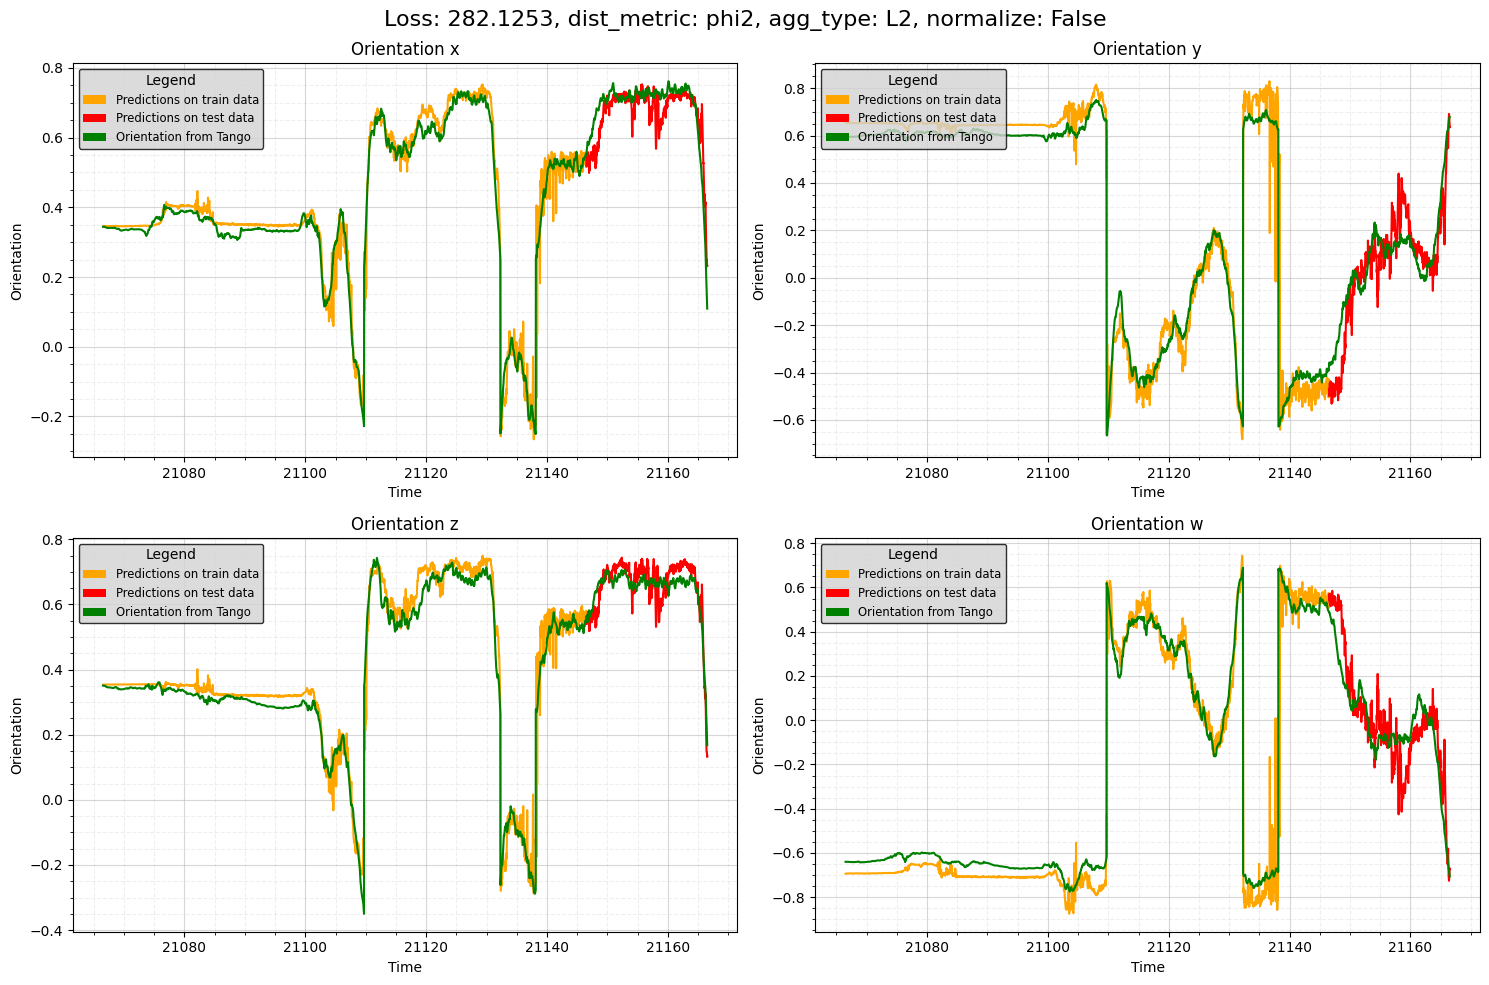

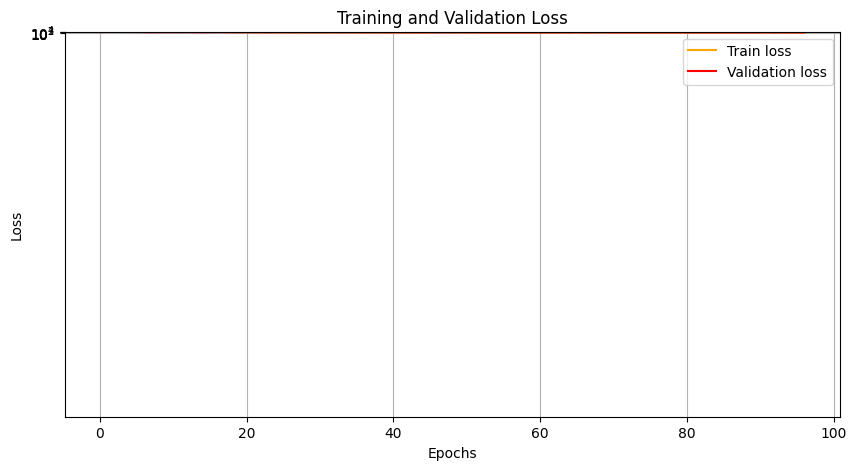

In [34]:
train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.Adam(model.parameters())

patience = 20
min_valid_loss = np.inf
patience_counter = 0

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    train_losses.append(loss.item())
    valid_losses.append(valid_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print('Early stopping')
        break

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)


plot_losses(train_losses, valid_losses)

In [35]:
class GRUOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        
        return out

Epoch 1/200, Train Loss: 15622.8242, Validation Loss: 11499.4873
Epoch 2/200, Train Loss: 48911.7422, Validation Loss: 3561.4854
Epoch 3/200, Train Loss: 34706.3281, Validation Loss: 1781.9552
Epoch 4/200, Train Loss: 13221.9170, Validation Loss: 3313.5530
Epoch 5/200, Train Loss: 10659.4521, Validation Loss: 1840.9656
Epoch 6/200, Train Loss: 5937.8999, Validation Loss: 851.3436
Epoch 7/200, Train Loss: 3692.3198, Validation Loss: 1171.2174
Epoch 8/200, Train Loss: 3798.7913, Validation Loss: 956.2809
Epoch 9/200, Train Loss: 3287.9250, Validation Loss: 935.8478
Epoch 10/200, Train Loss: 2916.2883, Validation Loss: 976.4502
Epoch 11/200, Train Loss: 2469.6772, Validation Loss: 971.6419
Epoch 12/200, Train Loss: 2379.1199, Validation Loss: 882.7977
Epoch 13/200, Train Loss: 1960.9595, Validation Loss: 866.6700
Epoch 14/200, Train Loss: 1839.1407, Validation Loss: 757.0198
Epoch 15/200, Train Loss: 1717.9261, Validation Loss: 753.2273
Epoch 16/200, Train Loss: 1474.6113, Validation Loss

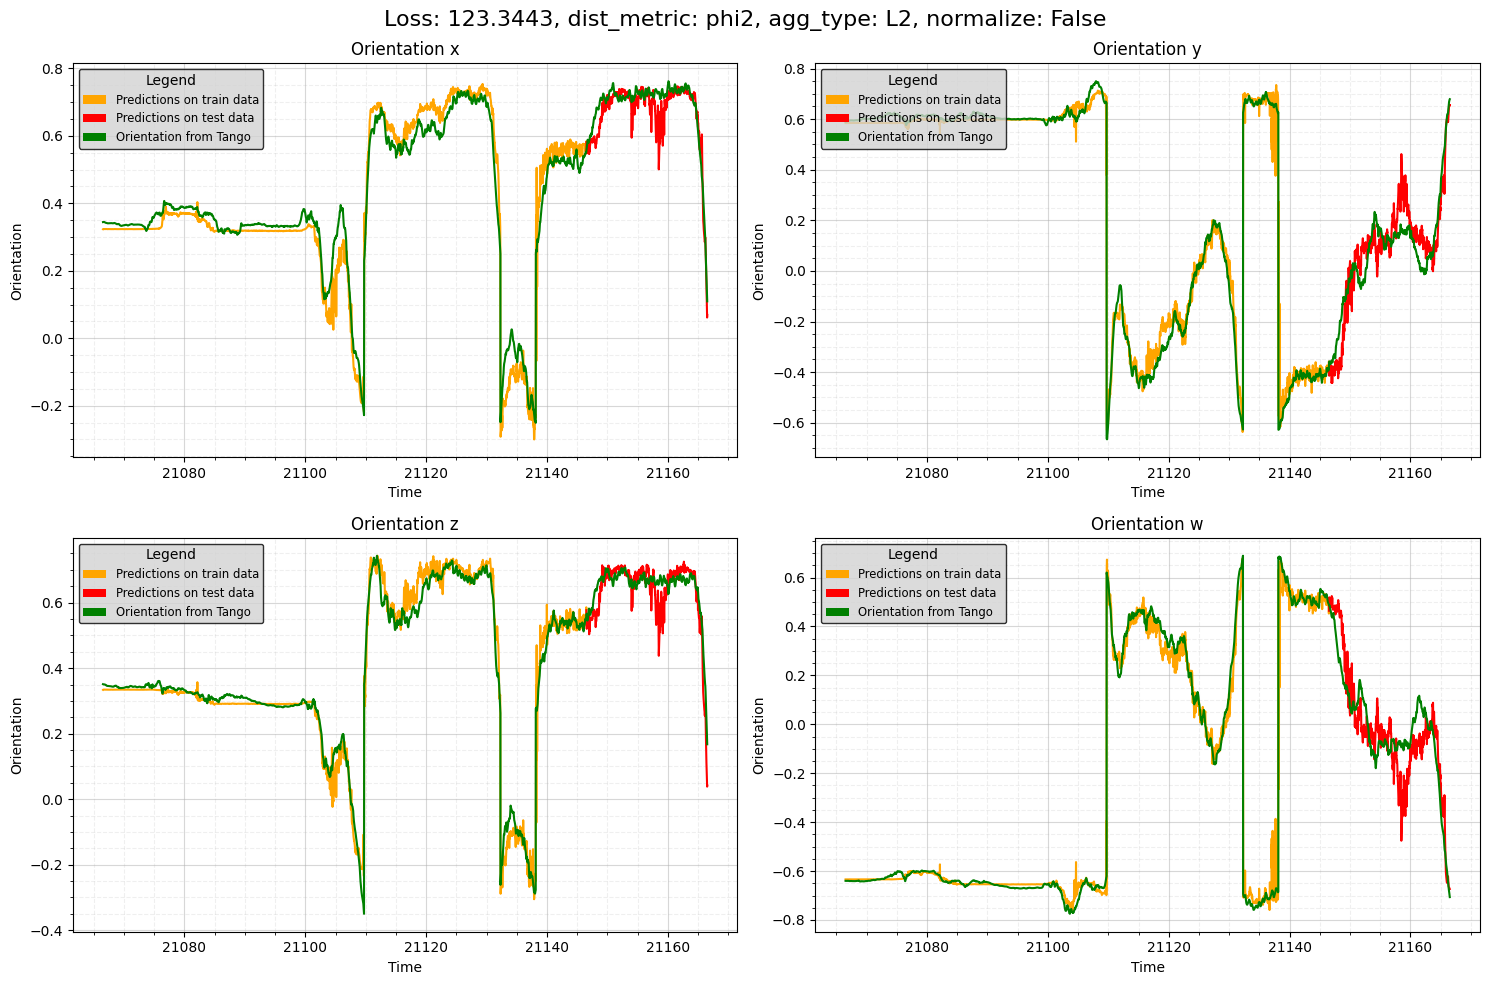

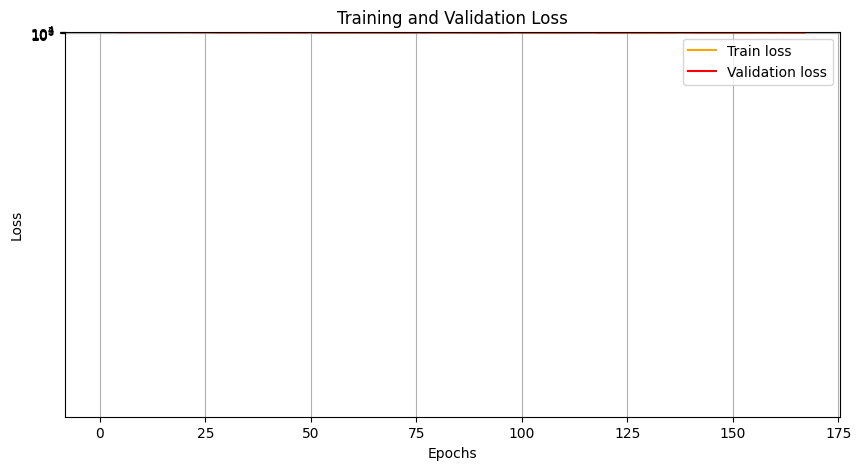

In [36]:
train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = GRUOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.Adam(model.parameters())

patience = 20
min_valid_loss = np.inf
patience_counter = 0

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    train_losses.append(loss.item())
    valid_losses.append(valid_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print('Early stopping')
        break

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)


plot_losses(train_losses, valid_losses)

In [37]:
class RNNOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        
        return out


Epoch 1/200, Train Loss: 16459.3984, Validation Loss: 75117.1484
Epoch 2/200, Train Loss: 364173.0000, Validation Loss: 52015.2617
Epoch 3/200, Train Loss: 299174.8750, Validation Loss: 22367.1113
Epoch 4/200, Train Loss: 99240.3828, Validation Loss: 2676.9260
Epoch 5/200, Train Loss: 27627.5781, Validation Loss: 7929.0132
Epoch 6/200, Train Loss: 50823.1172, Validation Loss: 1919.7648
Epoch 7/200, Train Loss: 19046.4473, Validation Loss: 3488.3401
Epoch 8/200, Train Loss: 18164.4805, Validation Loss: 4494.2319
Epoch 9/200, Train Loss: 19089.4395, Validation Loss: 4021.6492
Epoch 10/200, Train Loss: 16102.6611, Validation Loss: 2621.3894
Epoch 11/200, Train Loss: 13697.8281, Validation Loss: 986.1210
Epoch 12/200, Train Loss: 13282.7422, Validation Loss: 928.3049
Epoch 13/200, Train Loss: 13015.0508, Validation Loss: 1828.5074
Epoch 14/200, Train Loss: 10979.5645, Validation Loss: 2238.9690
Epoch 15/200, Train Loss: 11128.3428, Validation Loss: 1843.0409
Epoch 16/200, Train Loss: 9940.

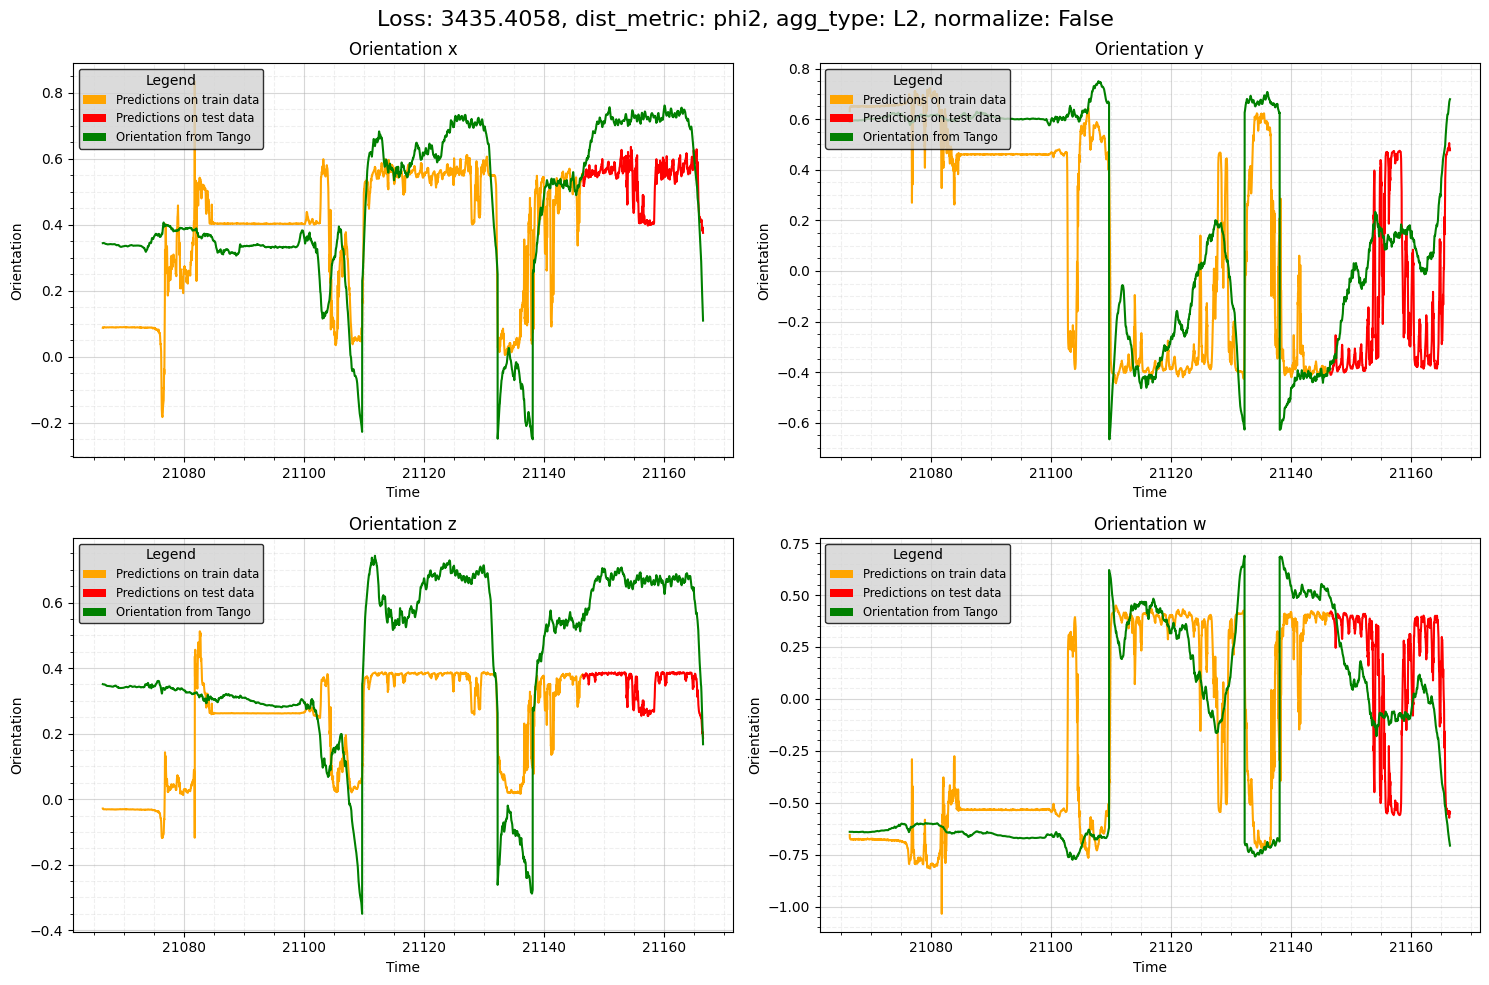

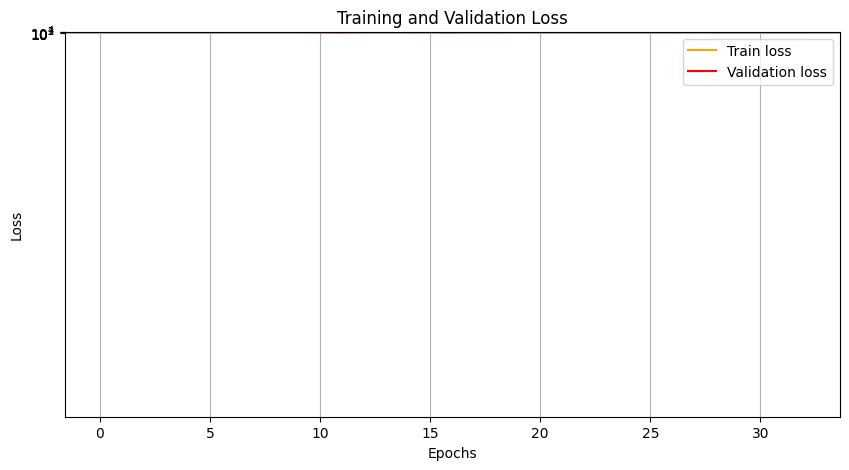

In [38]:
train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = RNNOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.Adam(model.parameters())

patience = 20
min_valid_loss = np.inf
patience_counter = 0

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    train_losses.append(loss.item())
    valid_losses.append(valid_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print('Early stopping')
        break

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)


plot_losses(train_losses, valid_losses)